<a href="https://colab.research.google.com/github/dikshyantacharya/opencampus-chess/blob/main/Chess_ReinforcementLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chess
import chess
import csv
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, Flatten, Input, Concatenate
import random
import keras
from keras.layers import Input
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00


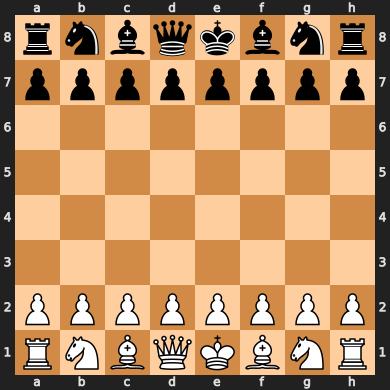

In [3]:
board = chess.Board()
board

In [4]:
def board_to_input(board):
    # Define a mapping for pieces to integers
    piece_to_value = {
        (chess.PAWN, chess.WHITE): 1,
        (chess.KNIGHT, chess.WHITE): 2,
        (chess.BISHOP, chess.WHITE): 3,
        (chess.ROOK, chess.WHITE): 4,
        (chess.QUEEN, chess.WHITE): 5,
        (chess.KING, chess.WHITE): 6,
        (chess.PAWN, chess.BLACK): 7,
        (chess.KNIGHT, chess.BLACK): 8,
        (chess.BISHOP, chess.BLACK): 9,
        (chess.ROOK, chess.BLACK): 10,
        (chess.QUEEN, chess.BLACK): 11,
        (chess.KING, chess.BLACK): 12
    }

    # 8x8 grid with 14 channels: 12 for pieces, 1 for castling rights, 1 for side to move
    board_representation = np.zeros((8, 8, 17), dtype=int)

    # Fill the board representation with values for each piece
    for square in chess.SQUARES:
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_to_value.get((piece.piece_type, piece.color))
            board_representation[rank, file, value - 1] = 1

    # Castling rights and side to move
    castling_rights_white_kingside = int(board.has_kingside_castling_rights(chess.WHITE))
    castling_rights_white_queenside = int(board.has_queenside_castling_rights(chess.WHITE))
    castling_rights_black_kingside = int(board.has_kingside_castling_rights(chess.BLACK))
    castling_rights_black_queenside = int(board.has_queenside_castling_rights(chess.BLACK))
    side_to_move = int(board.turn == chess.WHITE)

    # Add castling rights and side to move to the last two channels uniformly
    board_representation[:, :, 12] = castling_rights_white_kingside
    board_representation[:, :, 13] = castling_rights_white_queenside
    board_representation[:, :, 14] = castling_rights_black_kingside
    board_representation[:, :, 15] = castling_rights_black_queenside
    board_representation[:, :, 16] = side_to_move

    return board_representation

In [5]:
def create_dual_output_model():
    # Input layer
    inputs = Input(shape=(8, 8, 17))

    # Common convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)

    # Shared dense layer
    shared_dense = Dense(50, activation='relu')(x)
    dropout = Dropout(0.5)(shared_dense)

    # Policy head
    policy_dense = Dense(4672, activation='softmax', name='policy_output')(dropout)

    # Value head - adjusting to output between 0 and 1 as per your requirement
    value_dense = Dense(1, activation='sigmoid', name='value_output')(dropout) # Using sigmoid to get output between 0 and 1

    # Create the dual output model
    model = Model(inputs=inputs, outputs=[policy_dense, value_dense])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss={'policy_output': 'categorical_crossentropy', 'value_output': 'mean_squared_error'},
                  metrics={'policy_output': 'accuracy', 'value_output': 'mse'})

    return model

# Create the model
model = create_dual_output_model()

# Print model summary to verify architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 17)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 32)             4928      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 4096)                 0         ['conv2d_1[0][0]']            
                                                                                              

In [6]:
# Apply monte carlo tree search for this

def select_highest_probability_move(probabilities, board):
    # Ensure there are legal moves to choose from
    valid_moves = list(board.legal_moves)
    if not valid_moves:
        raise ValueError("No valid moves available.")

    highest_prob = -1
    best_move = None

    for move in valid_moves:
        move_index = move_to_index(move, board)  # Convert move to index
        if probabilities[move_index] > highest_prob:
            highest_prob = probabilities[move_index]
            best_move = move

    if best_move is None:
        raise ValueError("Failed to select a highest probability move.")

    return best_move


In [7]:
# Apply monte carlo tree search for this

def select_lowest_probability_move(probabilities, board):
    # Ensure there are legal moves to choose from
    valid_moves = list(board.legal_moves)
    if not valid_moves:
        raise ValueError("No valid moves available.")

    lowest_probab = 2
    best_move = None

    for move in valid_moves:
        move_index = move_to_index(move, board)  # Convert move to index
        if probabilities[move_index] < lowest_probab:
            lowest_probab = probabilities[move_index]
            best_move = move

    if best_move is None:
        raise ValueError("Failed to select a highest probability move.")

    return best_move


In [8]:
def calculate_knight_to_square(from_square, direction):
    # Mapping direction to board movements for a knight
    knight_moves = {
        0: (-2, -1),  # North Left
        1: (-2, 1),   # North Right
        2: (-1, 2),   # East Up
        3: (1, 2),    # East Down
        4: (2, 1),    # South Right
        5: (2, -1),   # South Left
        6: (1, -2),   # West Down
        7: (-1, -2)   # West Up
    }
    move = knight_moves[direction]
    from_row, from_col = divmod(from_square, 8)
    to_row = from_row + move[0]
    to_col = from_col + move[1]

    # Ensure the move stays within the bounds of the chessboard
    if 0 <= to_row < 8 and 0 <= to_col < 8:
        return chess.square(to_col, to_row)
    else:
        return None  # This indicates an invalid move


In [9]:
def calculate_queenlike_to_square(from_square, direction, distance):
    # Mapping direction to board movements for a queen
    queen_directions = {
        0: (-1, -1),  # Northwest
        1: (-1, 0),   # North
        2: (-1, 1),   # Northeast
        3: (0, 1),    # East
        4: (1, 1),    # Southeast
        5: (1, 0),    # South
        6: (1, -1),   # Southwest
        7: (0, -1)    # West
    }
    move = queen_directions[direction]
    from_row, from_col = divmod(from_square, 8)
    to_row = from_row + move[0] * distance
    to_col = from_col + move[1] * distance

    # Ensure the move stays within the bounds of the chessboard
    if 0 <= to_row < 8 and 0 <= to_col < 8:
        return chess.square(to_col, to_row)
    else:
        return None  # This indicates an invalid move


In [10]:
def calculate_underpromotion_to_square(from_square, promotion_category, direction, is_white_turn):
    # Assuming direction: 0 = forward, 1 = left diagonal, 2 = right diagonal
    # promotion_category is not directly used here but can determine the piece to promote to
    direction_mapping = {
        0: (-1, 0),  # Forward (for white, reverse for black)
        1: (-1, -1), # Left Diagonal (for white, reverse for black)
        2: (-1, 1)   # Right Diagonal (for white, reverse for black)
    }

    if not is_white_turn:  # If it's black's turn, reverse the direction
        direction_mapping = {
            0: (1, 0),  # Forward
            1: (1, 1),  # Left Diagonal (from black's perspective)
            2: (1, -1)  # Right Diagonal
        }

    move = direction_mapping[direction]
    from_row, from_col = divmod(from_square, 8)
    to_row = from_row + move[0]
    to_col = from_col + move[1]

    # Ensure the move stays within the bounds of the chessboard
    if 0 <= to_row < 8 and 0 <= to_col < 8:
        to_square = chess.square(to_col, to_row)
        # Determine the promotion piece based on the category
        promotion_piece = None
        if promotion_category == 0:  # Knight
            promotion_piece = chess.KNIGHT
        elif promotion_category == 1:  # Bishop
            promotion_piece = chess.BISHOP
        elif promotion_category == 2:  # Rook
            promotion_piece = chess.ROOK
        return to_square, promotion_piece
    else:
        return None, None  # This indicates an invalid move or invalid promotion


In [11]:
def move_to_index(move, board):
    from_square = move.from_square
    to_square = move.to_square

    piece = board.piece_at(from_square)
    if piece is None:
        raise ValueError("No piece at the from_square.")

    from_row, from_col = divmod(from_square, 8)
    to_row, to_col = divmod(to_square, 8)

    index = None

    if piece.piece_type == chess.KNIGHT:
        direction = calculate_knight_move_direction(from_row, from_col, to_row, to_col)
        if direction is not None:
            index = 64 * 7 + direction
    elif piece.piece_type == chess.KING:
        # Handle standard king moves and castling
        if board.is_castling(move):
            # Special encoding for castling moves
            if move.to_square == chess.G1 or move.to_square == chess.G8:
                # Kingside castle
                index = 64 * 9  # Example index, adjust based on your encoding
            else:
                # Queenside castle
                index = 64 * 9 + 1  # Example index, adjust based on your encoding
        else:
            # Standard king move, treated similarly to queen-like but with distance 1
            direction, distance = calculate_queenlike_move_direction_and_distance(from_row, from_col, to_row, to_col)
            if direction is not None:
                index = 64 * 8 + direction  # Adjust based on your encoding for king moves
    elif piece.piece_type in [chess.QUEEN, chess.BISHOP, chess.ROOK, chess.PAWN] and not move.promotion:
        direction, distance = calculate_queenlike_move_direction_and_distance(from_row, from_col, to_row, to_col)
        if direction is not None and distance is not None:
            index = direction * 8 + (distance - 1)
    elif move.promotion and move.promotion != chess.QUEEN:
        promotion_category, direction = calculate_underpromotion_category_and_direction(move, board)
        if promotion_category is not None and direction is not None:
            index = 64 * 8 + promotion_category * 3 + direction
    elif move.promotion and move.promotion == chess.QUEEN:
        direction, distance = calculate_queenlike_move_direction_and_distance(from_row, from_col, to_row, to_col)
        if direction is not None and distance is not None:
            index = direction * 8 + (distance - 1)

    if index is None:
        print("Move is ", move)
        raise ValueError("Could not determine move index.")

    return index


In [12]:
def index_to_move(index, board):
    # This function needs to be implemented based on your mapping logic
    move_uci = index_to_uci(index, board)
    if move_uci in [move.uci() for move in board.legal_moves]:
        return chess.Move.from_uci(move_uci)
    else:
        raise ValueError("Generated move is not legal.")

In [13]:
def calculate_queenlike_move_direction_and_distance(from_row, from_col, to_row, to_col):
    delta_row = to_row - from_row
    delta_col = to_col - from_col

    direction = None
    distance = max(abs(delta_row), abs(delta_col))

    if delta_row == 0 and delta_col > 0:
        direction = 3  # East
    elif delta_row == 0 and delta_col < 0:
        direction = 7  # West
    elif delta_row > 0 and delta_col == 0:
        direction = 5  # South
    elif delta_row < 0 and delta_col == 0:
        direction = 1  # North
    elif delta_row > 0 and delta_col > 0:
        direction = 4  # Southeast
    elif delta_row < 0 and delta_col < 0:
        direction = 0  # Northwest
    elif delta_row > 0 and delta_col < 0:
        direction = 6  # Southwest
    elif delta_row < 0 and delta_col > 0:
        direction = 2  # Northeast

    return direction, distance


In [14]:
def calculate_knight_move_direction(from_row, from_col, to_row, to_col):
    row_diff = to_row - from_row
    col_diff = to_col - from_col

    # Define all possible knight moves
    knight_moves = {
        (-2, -1): 0,
        (-2, 1): 1,
        (-1, 2): 2,
        (1, 2): 3,
        (2, 1): 4,
        (2, -1): 5,
        (1, -2): 6,
        (-1, -2): 7
    }

    return knight_moves.get((row_diff, col_diff))


In [15]:
def calculate_underpromotion_category_and_direction(move, board):
    from_square = move.from_square
    to_square = move.to_square

    from_row, from_col = divmod(from_square, 8)
    to_row, to_col = divmod(to_square, 8)

    delta_row = to_row - from_row
    delta_col = to_col - from_col

    direction = None
    if delta_col == 0:
        direction = 0  # Forward
    elif delta_col == 1:
        direction = 2  # Right Diagonal
    elif delta_col == -1:
        direction = 1  # Left Diagonal

    # Determine the promotion category based on the promoted piece type
    if move.promotion == chess.KNIGHT:
        promotion_category = 0
    elif move.promotion == chess.BISHOP:
        promotion_category = 1
    elif move.promotion == chess.ROOK:
        promotion_category = 2
    else:
        raise ValueError("Invalid promotion piece.")

    return promotion_category, direction


In [16]:
def index_to_uci(index, board):
    return index
    index = int(index)  # Ensure index is an integer
    square = index % 64  # Find the square involved
    category = index // 64  # Determine the category of move

    # Convert square index to board position
    from_row, from_col = divmod(square, 8)
    from_square = chess.square(from_col, from_row)

    to_square = None
    promotion_piece = None

    if category < 56:  # Queen-like moves
        direction = category // 7
        distance = category % 7 + 1
        to_square = calculate_queenlike_to_square(from_square, direction, distance)
    elif category < 64:  # Knight moves
        direction = category - 56
        to_square = calculate_knight_to_square(from_square, direction)
    else:  # Underpromotions
        promotion_category = (category - 64) // 3
        direction = (category - 64) % 3
        to_square, promotion_piece = calculate_underpromotion_to_square(from_square, promotion_category, direction, board.turn)

    if to_square is None:
        raise ValueError("Could not calculate destination square.")

    move = chess.Move(from_square, to_square, promotion=promotion_piece)

    if move not in board.legal_moves:
        raise ValueError(f"Generated move {move.uci()} is not legal in the current board state.")

    return move.uci()


In [17]:
def play_game(board, model):
    # Convert the board to the input format expected by the model
    board_input = board_to_input(board)
    # Predict the policy (move probabilities) and value from the current board state
    policy, value = model.predict(board_input[np.newaxis, :])  # Adding batch dimension

    # Determine the side to play (True for white, False for black)
    is_white_turn = board.turn

    # Adjust move selection strategy based on whose turn it is
    if is_white_turn:
        # For white, select the highest probability move that maximizes the value
        move = select_highest_probability_move(policy[0], board)
    else:
        # For black, select the highest probability move that maximizes the value
        move = select_lowest_probability_move(policy[0], board)

    # Execute the move on the board
    uci_move = index_to_uci(move, board)  # Convert the selected move index to UCI format

    board.push(move)  # Make the move

    return board, policy[0], uci_move, board_input  # Return the updated board, chosen policy, and UCI move


In [18]:
def calculate_total_value(board):
    # Assign values to each piece type
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9
    }

    white_value = 0
    black_value = 0

    # Iterate over all squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            # Add the value of the piece to either white_value or black_value based on the piece color
            if piece.color == chess.WHITE:
                white_value += piece_values.get(piece.piece_type, 0)
            else:
                black_value += piece_values.get(piece.piece_type, 0)

    # Subtract black's total value from white's total value
    net_value = white_value - black_value
    return net_value

In [19]:
def assign_values(game_data, result, board):
    outcome = 0  # Draw
    if result == "1-0":
        outcome = 1  # White win
    elif result == "0-1":
        outcome = -1  # Black win
    else:
        board_value = calculate_total_value(board)
        print("Board_value is: ", board_value)
        display(board)
        if board_value >= 5:
          outcome = 0.25
        elif board_value <= -5:
          outcome = -0.25
    # Update the game data with the outcome
    for item in game_data:
        item[-1] = outcome  # This is now allowed since item is a list


In [20]:
def generateData():
    board = chess.Board()
    model = create_dual_output_model()
    game_data = []  # To collect game states, moves, and policies

    while not board.is_game_over(claim_draw=True):
        board, policy, uci_move, board_input = play_game(board, model)

        # Collect data: board state and policy; outcome will be assigned later
        game_data.append([board_input, policy, None])  # Store FEN for simplicity

    # Assign outcome values to the collected data
    assign_values(game_data, board.result(), board)

    # Save the game data for training
    save_game_data(game_data)

    print("Game Over")
    print("Result:", board.result())

In [21]:
def save_game_data(game_data, file_name="game_data.csv"):
    # Open the CSV file for writing
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['chess position', 'policy head', 'value head'])

        # Temporarily set numpy print options to ensure full array serialization
        np.set_printoptions(threshold=np.inf)

        # Iterate over game_data and write each move
        for move in game_data:
            # Serialize the board position and policy to strings without abbreviation
            board_str = np.array2string(move[0], separator=',').replace('\n', '').replace(' ', '').replace('[[', '[').replace(']]', ']')
            policy_str = np.array2string(move[1], separator=',').replace('\n', '').replace(' ', '')
            outcome = move[2]  # Outcome is already in the correct format

            # Write the move data to the CSV file
            writer.writerow([board_str, policy_str, outcome])

        # Reset numpy print options to default
        np.set_printoptions(threshold=1000)

1/1 [==============================] - 0s 23ms/step
Board_value is:  0


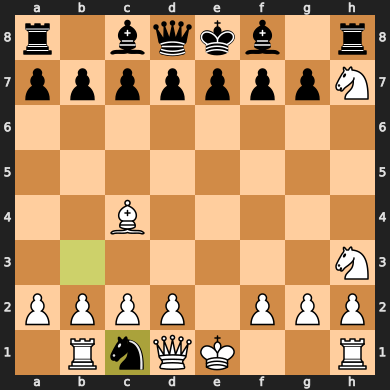

Game Over
Result: *


In [22]:
generateData()